In [1]:
from os import getcwd, path
import sys

BASE_PATH = path.dirname(getcwd())
sys.path.append(BASE_PATH)

In [2]:
MODEL_PATH = path.join(BASE_PATH, 'output/model/checkpoint_116_88.52.bin')
print(MODEL_PATH)

/Users/2359media/Documents/botbot-nlp/output/model/checkpoint_116_88.52.bin


In [3]:
import torch
from sent_to_vec.model import *

ENCODER_DIM = 2400
encoder = QRNNEncoder(hidden_dim=ENCODER_DIM, num_layers=3)
nli_net = NLINet(encoder=encoder, lstm_dim=ENCODER_DIM, bidirectional_encoder=False)

cp_data = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
nli_net.load_state_dict(cp_data['nli_state'])
print('lr: %s, step: %s' % (cp_data['optimizer_state']['param_groups'][0]['lr'], cp_data['epoch']))

lr: 0.2, step: 116


In [4]:
import torch.nn.functional as F

def encode(sent, batch=False):
    if not batch:
        sent_input = process_input([sent])
        print(sent_input)
    else:
        sent_input = process_input(sent)
    sent_batch, sent_len = process_batch(sent_input)
    encoder.eval()
    embs = encoder((sent_batch, sent_len))
    encoder.train()
    if not batch and len(embs.size()) > 1:
        embs = embs.squeeze(0)
    return embs.data.numpy()

target_dict = {'entailment': 0, 'neutral': 1, 'contradiction': 2}
target_dict = {v:k for k, v in target_dict.items()} # invert
def test(sent1, sent2):
    sent1 = process_input([sent1])
    sent2 = process_input([sent2])
    sent1_batch = process_batch(sent1)
    sent2_batch = process_batch(sent2)
    nli_net.eval()
    result = F.softmax(nli_net(sent1_batch, sent2_batch), dim=-1)
    nli_net.train()
    scores, idxs = torch.max(result, dim=-1)
#     print(scores[0])
    return target_dict[idxs.data.numpy()[0]] + (' (%s%%)' % str(scores[0].item() * 100))

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [5]:
embs = encode('I\'d like to order a coffee')
print(embs)
print(embs.size)

[['<START>', 'I', "'d", 'like', 'to', 'order', 'a', 'coffee', '<STOP>']]
[ 0.05330659  0.01268003  0.14816067 ... -0.03455034  0.05179404
 -0.11401987]
2400


In [6]:
test('This church choir sings to the masses as they sing joyous songs from the book at a church . ', 
     'The church is filled with song . ')

'entailment (99.99880194664001%)'

In [7]:
test('This church choir sings to the masses as they sing joyous songs from the book at a church . ', 
     'The church has cracks in the ceiling .')

'entailment (87.83190250396729%)'

In [8]:
test('barrack-obama was the president of the united states', 'donald trump is the president of the united states')

'neutral (58.81591439247131%)'

In [9]:
test('barrack-obama was the president of the united states', 'barrack-obama is the president of the united states')

'entailment (99.99815821647644%)'

In [10]:
import matplotlib.pyplot as plt

def visualize(text):
    sent_input = [text]
    sent_input = process_input(sent_input)
    sent_batch, sent_len = process_batch(sent_input)

    encoder.eval()
    output = encoder.qrnn(sent_batch)[0] # take output; skip hidden
    encoder.train()
    output, idxs = torch.max(output, 0)
    idxs = idxs.data.numpy()
    print(idxs)
    print(idxs.size)

    x = range(len(sent_input[0]))[1:-1]
    argmaxs = [np.sum((idxs == k)) for k in range(len(sent_input[0]))]
    y = [100.0 * n / np.sum(argmaxs) for n in argmaxs][1:-1]
    plt.xticks(x, sent_input[0][1:-1], rotation=45)
    plt.bar(x, y)
    plt.ylabel('%')
    plt.title('Visualisation of words importance')
    plt.show()

[[10  1  9 ...  7 10  0]]
2400


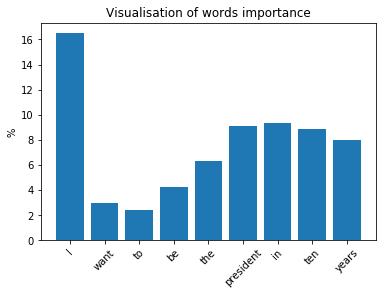

In [11]:
visualize('I want to be the president in ten years')

[[2 2 6 ... 9 2 6]]
2400


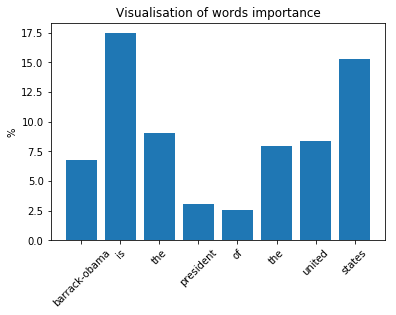

In [12]:
visualize('barrack-obama is the president of the united states')

[[9 1 6 ... 1 1 5]]
2400


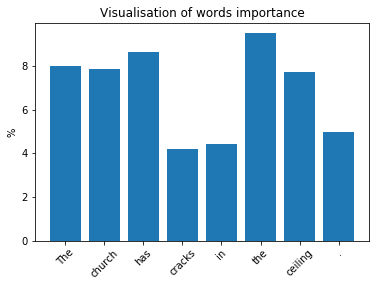

In [13]:
visualize('The church has cracks in the ceiling .')

In [ ]:
import csv

TRAIN_PATH = path.join(BASE_PATH, 'data/MSRParaphraseCorpus/msr_paraphrase_train.txt')
TEST_PATH = path.join(BASE_PATH, 'data/MSRParaphraseCorpus/msr_paraphrase_test.txt')

def read_MSRParaphraseCorpus(file_path):
    target = []
    sent1 = []
    sent2 = []
    with open(file_path, 'r') as input_file:
        reader = csv.DictReader(input_file, delimiter='\t', quoting=csv.QUOTE_NONE)
        for row in reader:
            target.append(int(row['\ufeffQuality']))
            sent1.append(row['#1 String'])
            sent2.append(row['#2 String'])
    return sent1, sent2, target

def process_MSRParaphras(sent1_batch, sent2_batch, target_batch):
    return np.concatenate(
            (encode(sent1_batch, batch=True), encode(sent2_batch, batch=True)),
        axis=1), np.array(target_batch)

In [ ]:
sent1_train, sent2_train, target_train = read_MSRParaphraseCorpus(TRAIN_PATH)
print('Train set sentence pairs: %s' % len(sent1_train))
sent_batch, target_batch = process_MSRParaphras(sent1_train, sent2_train, target_train)

Train set sentence pairs: 4076
